##**Recipe Recommender: A Nutritional Distance-Based Approach**

Connecting to google drive to obtain dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


Unzipping raw-data-images file to google drive

In [ ]:
#importing package to unzip the file
from zipfile import ZipFile

In [ ]:
#unzipping the file and saving it to google drive
with ZipFile('/content/drive/MyDrive/raw-data-images.zip', 'r') as zipObj:
  zipObj.extractall('/content/drive/MyDrive/raw-data-images')

importing necessary packages

In [ ]:
#importing necessary packages
import pandas as pd
import ast
from scipy.spatial.distance import cosine, euclidean, hamming
from sklearn.preprocessing import normalize
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from time import time
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors

loading the dataset

In [ ]:
#reading the dataset into recipe
recipe = pd.read_csv('/content/drive/MyDrive/raw-data_recipe.csv')
recipe.head()

recipe_id                        recipe_name  aver_rate  \
0     222388                     Homemade Bacon   5.000000   
1     240488  Pork Loin, Apples, and Sauerkraut   4.764706   
2     218939   Foolproof Rosemary Chicken Wings   4.571429   
3      87211              Chicken Pesto Paninis   4.625000   
4     245714                 Potato Bacon Pizza   4.500000   

                                           image_url  review_nums  \
0  https://images.media-allrecipes.com/userphotos...            3   
1  https://images.media-allrecipes.com/userphotos...           29   
2  https://images.media-allrecipes.com/userphotos...           12   
3  https://images.media-allrecipes.com/userphotos...          163   
4  https://images.media-allrecipes.com/userphotos...            2   

                                         ingredients  \
0  pork belly^smoked paprika^kosher salt^ground b...   
1  sauerkraut drained^Granny Smith apples sliced^...   
2  chicken wings^sprigs rosemary^head garlic^oliv...   
3  focaccia bread quartered^prepared basil pesto^...   
4  red potatoes^strips bacon^Sauce:^heavy whippin...   

                                  cooking_directions  \
0  {'directions': u'Prep\n5 m\nCook\n2 h 45 m\nRe...   
1  {'directions': u'Prep\n15 m\nCook\n2 h 30 m\nR...   
2  {'directions': u"Prep\n20 m\nCook\n40 m\nReady...   
3  {'directions': u'Prep\n15 m\nCook\n5 m\nReady ...   
4  {'directions': u'Prep\n20 m\nCook\n45 m\nReady...   

                                          nutritions  \
0  {u'niacin': {u'hasCompleteData': False, u'name...   
1  {u'niacin': {u'hasCompleteData': False, u'name...   
2  {u'niacin': {u'hasCompleteData': True, u'name'...   
3  {u'niacin': {u'hasCompleteData': True, u'name'...   
4  {u'niacin': {u'hasCompleteData': True, u'name'...   

                                             reviews  
0  {8542392: {'rating': 5, 'followersCount': 11, ...  
1  {3574785: {'rating': 5, 'followersCount': 0, '...  
2  {13774946: {'rating': 5, 'followersCount': 0, ...  
3  {1563136: {'rating': 5, 'followersCount': 0, '...  
4  {2945555: {'rating': 5, 'followersCount': 6690...

Data Preprocessing

In [ ]:
#dropping image_url, cooking_directions, reviews columns
recipe = recipe.drop(columns=['image_url', 'cooking_directions', 'reviews'])
recipe.head()

recipe_id                        recipe_name  aver_rate  review_nums  \
0     222388                     Homemade Bacon   5.000000            3   
1     240488  Pork Loin, Apples, and Sauerkraut   4.764706           29   
2     218939   Foolproof Rosemary Chicken Wings   4.571429           12   
3      87211              Chicken Pesto Paninis   4.625000          163   
4     245714                 Potato Bacon Pizza   4.500000            2   

                                         ingredients  \
0  pork belly^smoked paprika^kosher salt^ground b...   
1  sauerkraut drained^Granny Smith apples sliced^...   
2  chicken wings^sprigs rosemary^head garlic^oliv...   
3  focaccia bread quartered^prepared basil pesto^...   
4  red potatoes^strips bacon^Sauce:^heavy whippin...   

                                          nutritions  
0  {u'niacin': {u'hasCompleteData': False, u'name...  
1  {u'niacin': {u'hasCompleteData': False, u'name...  
2  {u'niacin': {u'hasCompleteData': True, u'name'...  
3  {u'niacin': {u'hasCompleteData': True, u'name'...  
4  {u'niacin': {u'hasCompleteData': True, u'name'...

In [ ]:
# function to round average rating into 2 decimal places
def avg_rate(col):
    return f'{col:.2f}'

In [ ]:
#rounding the average rating in the data to two decimal places
recipe.aver_rate = recipe.aver_rate.apply(avg_rate)
recipe.head()

recipe_id                        recipe_name aver_rate  review_nums  \
0     222388                     Homemade Bacon      5.00            3   
1     240488  Pork Loin, Apples, and Sauerkraut      4.76           29   
2     218939   Foolproof Rosemary Chicken Wings      4.57           12   
3      87211              Chicken Pesto Paninis      4.62          163   
4     245714                 Potato Bacon Pizza      4.50            2   

                                         ingredients  \
0  pork belly^smoked paprika^kosher salt^ground b...   
1  sauerkraut drained^Granny Smith apples sliced^...   
2  chicken wings^sprigs rosemary^head garlic^oliv...   
3  focaccia bread quartered^prepared basil pesto^...   
4  red potatoes^strips bacon^Sauce:^heavy whippin...   

                                          nutritions  
0  {u'niacin': {u'hasCompleteData': False, u'name...  
1  {u'niacin': {u'hasCompleteData': False, u'name...  
2  {u'niacin': {u'hasCompleteData': True, u'name'...  
3  {u'niacin': {u'hasCompleteData': True, u'name'...  
4  {u'niacin': {u'hasCompleteData': True, u'name'...

In [ ]:
recipe_names = recipe[['recipe_id','recipe_name']]

In [ ]:
recipe_names.head()

recipe_id                        recipe_name
0     222388                     Homemade Bacon
1     240488  Pork Loin, Apples, and Sauerkraut
2     218939   Foolproof Rosemary Chicken Wings
3      87211              Chicken Pesto Paninis
4     245714                 Potato Bacon Pizza

In [ ]:
#checking the data types of data
recipe.dtypes

recipe_id       int64
recipe_name    object
aver_rate      object
review_nums     int64
ingredients    object
nutritions     object
dtype: object

In [ ]:
#converting data type of aver_rate from object to float
recipe.aver_rate = recipe.aver_rate.astype(float)
recipe.dtypes

recipe_id        int64
recipe_name     object
aver_rate      float64
review_nums      int64
ingredients     object
nutritions      object
dtype: object

In [ ]:
#checking number of rows and columns in data
recipe.shape

(49698, 6)

In [ ]:
# counting total number of unique recipes
recipe.recipe_id.nunique()

49698

In [ ]:
#extracting nutritions column
recipe.nutritions[0]

"{u'niacin': {u'hasCompleteData': False, u'name': u'Niacin Equivalents', u'amount': 9.319291, u'percentDailyValue': u'72', u'displayValue': u'9', u'unit': u'mg'}, u'sugars': {u'hasCompleteData': True, u'name': u'Sugars', u'amount': 0.09355932, u'percentDailyValue': u'0', u'displayValue': u'0.1', u'unit': u'g'}, u'sodium': {u'hasCompleteData': True, u'name': u'Sodium', u'amount': 2017.13, u'percentDailyValue': u'81', u'displayValue': u'2017', u'unit': u'mg'}, u'carbohydrates': {u'hasCompleteData': True, u'name': u'Carbohydrates', u'amount': 1.797819, u'percentDailyValue': u'< 1', u'displayValue': u'1.8', u'unit': u'g'}, u'vitaminB6': {u'hasCompleteData': False, u'name': u'Vitamin B6', u'amount': 0.2329798, u'percentDailyValue': u'15', u'displayValue': u'< 1', u'unit': u'mg'}, u'calories': {u'hasCompleteData': True, u'name': u'Calories', u'amount': 308.1481, u'percentDailyValue': u'15', u'displayValue': u'308', u'unit': u'kcal'}, u'thiamin': {u'hasCompleteData': False, u'name': u'Thiamin

In [ ]:
#describing average rating
recipe[['aver_rate']].describe().transpose()

count      mean       std  min   25%   50%   75%  max
aver_rate  49698.0  4.311715  0.485338  0.0  4.08  4.41  4.62  5.0

In [ ]:
#function to find minimum and maximum rating
def find_min_max_rating():
    print('The minimum rating is: %d' %(recipe['aver_rate'].min()))
    print('The maximum rating is: %d' %(recipe['aver_rate'].max()))
#finding maximum and minimum rating
find_min_max_rating()

The minimum rating is: 0
The maximum rating is: 5


In [ ]:
# turning nutritions data from string to dictionary
list_of_dict = []

for row in recipe.nutritions:
    list_of_dict.append(ast.literal_eval(row))

In [ ]:
# extracting percent daily values for selected nutritions
calories_list = []
fat_list = []
carbohydrates_list = []
protein_list = []
cholesterol_list = []
sodium_list = []
fiber_list = []

for x in range(len(list_of_dict)):
    calories_list.append(list_of_dict[x]['calories']['percentDailyValue'])
    fat_list.append(list_of_dict[x]['fat']['percentDailyValue'])
    carbohydrates_list.append(list_of_dict[x]['carbohydrates']['percentDailyValue'])
    protein_list.append(list_of_dict[x]['protein']['percentDailyValue'])
    cholesterol_list.append(list_of_dict[x]['cholesterol']['percentDailyValue'])
    sodium_list.append(list_of_dict[x]['sodium']['percentDailyValue'])
    fiber_list.append(list_of_dict[x]['fiber']['percentDailyValue'])

In [ ]:
# grouping all the nutritions data into dataframe
data = {'calories': calories_list, 'fat': fat_list, 'carbohydrates': carbohydrates_list,
       'protein': protein_list, 'cholesterol': cholesterol_list, 'sodium': sodium_list,
       'fiber': fiber_list}

df = pd.DataFrame(data)
df.index = recipe['recipe_id']
df.head()

calories fat carbohydrates protein cholesterol sodium fiber
recipe_id                                                            
222388          15  36           < 1      42          21     81     2
240488          19  18            10      73          33    104    41
218939          17  36             2      48          24     31     4
87211           32  45            20      65          20     43    18
245714           8  12             5      14           7      8     3

Handling missing values

In [ ]:
#checking the data for null values
df.isnull().sum()

calories         963
fat              963
carbohydrates    963
protein          963
cholesterol      963
sodium           963
fiber            963
dtype: int64

In [ ]:
#dropping null values
print(df.shape)
df = df.dropna()
df.shape

(49698, 7)


(48735, 7)

In [ ]:
# imputing string data into numeric value
def text_cleaning(cols):
    if cols == '< 1':
        return 1
    else:
        return cols

In [ ]:
#applying text_cleaning function to all columns
for col in df.columns:
    df[col] = df[col].apply(text_cleaning)

In [ ]:
df

calories fat carbohydrates protein cholesterol sodium fiber
recipe_id                                                            
222388          15  36             1      42          21     81     2
240488          19  18            10      73          33    104    41
218939          17  36             2      48          24     31     4
87211           32  45            20      65          20     43    18
245714           8  12             5      14           7      8     3
...            ...  ..           ...     ...         ...    ...   ...
222886          20   1             6       1           0      1     0
25650            6  14             2       4          13      3     1
23544            8   7             8      10           3      3     8
170710          20  33            16      11          25      7     5
79774            2   3             2       3           0     16     6

[48735 rows x 7 columns]

In [ ]:
df.isna().sum()

calories         0
fat              0
carbohydrates    0
protein          0
cholesterol      0
sodium           0
fiber            0
dtype: int64

In [ ]:
df.dtypes

calories         object
fat              object
carbohydrates    object
protein          object
cholesterol      object
sodium           object
fiber            object
dtype: object

In [ ]:
#changing data type of all columns from object to integer
df = df.apply(pd.to_numeric)
df.dtypes

calories         int64
fat              int64
carbohydrates    int64
protein          int64
cholesterol      int64
sodium           int64
fiber            int64
dtype: object

Data Visualization

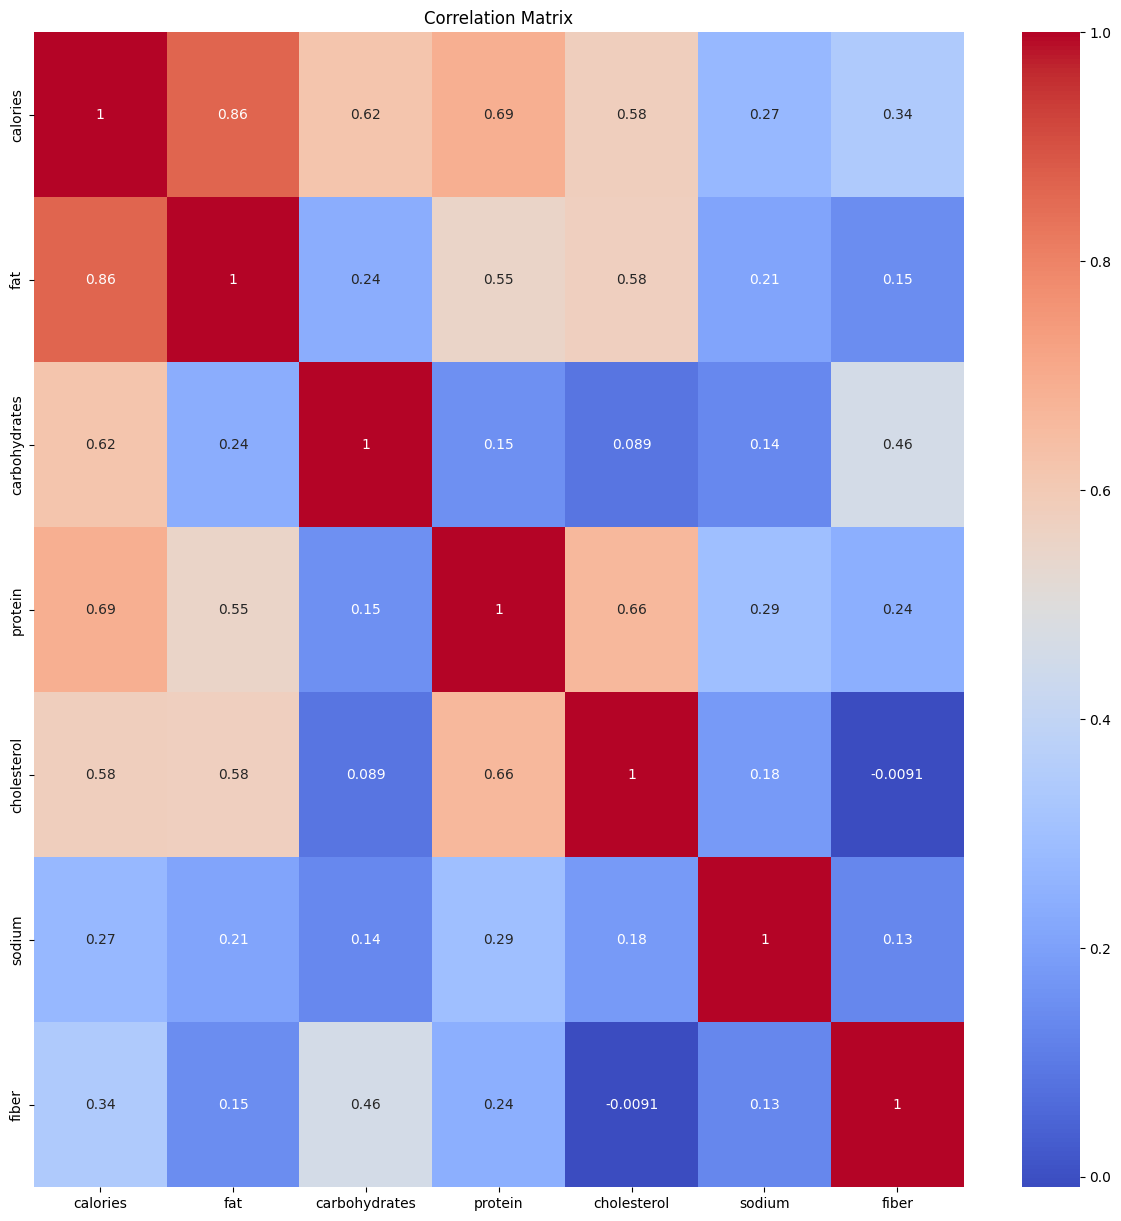

In [ ]:
#Obtaining correlation matrix
corr = df.select_dtypes(include=['int64', 'float64']).corr()
plt.figure(figsize=(15, 15))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

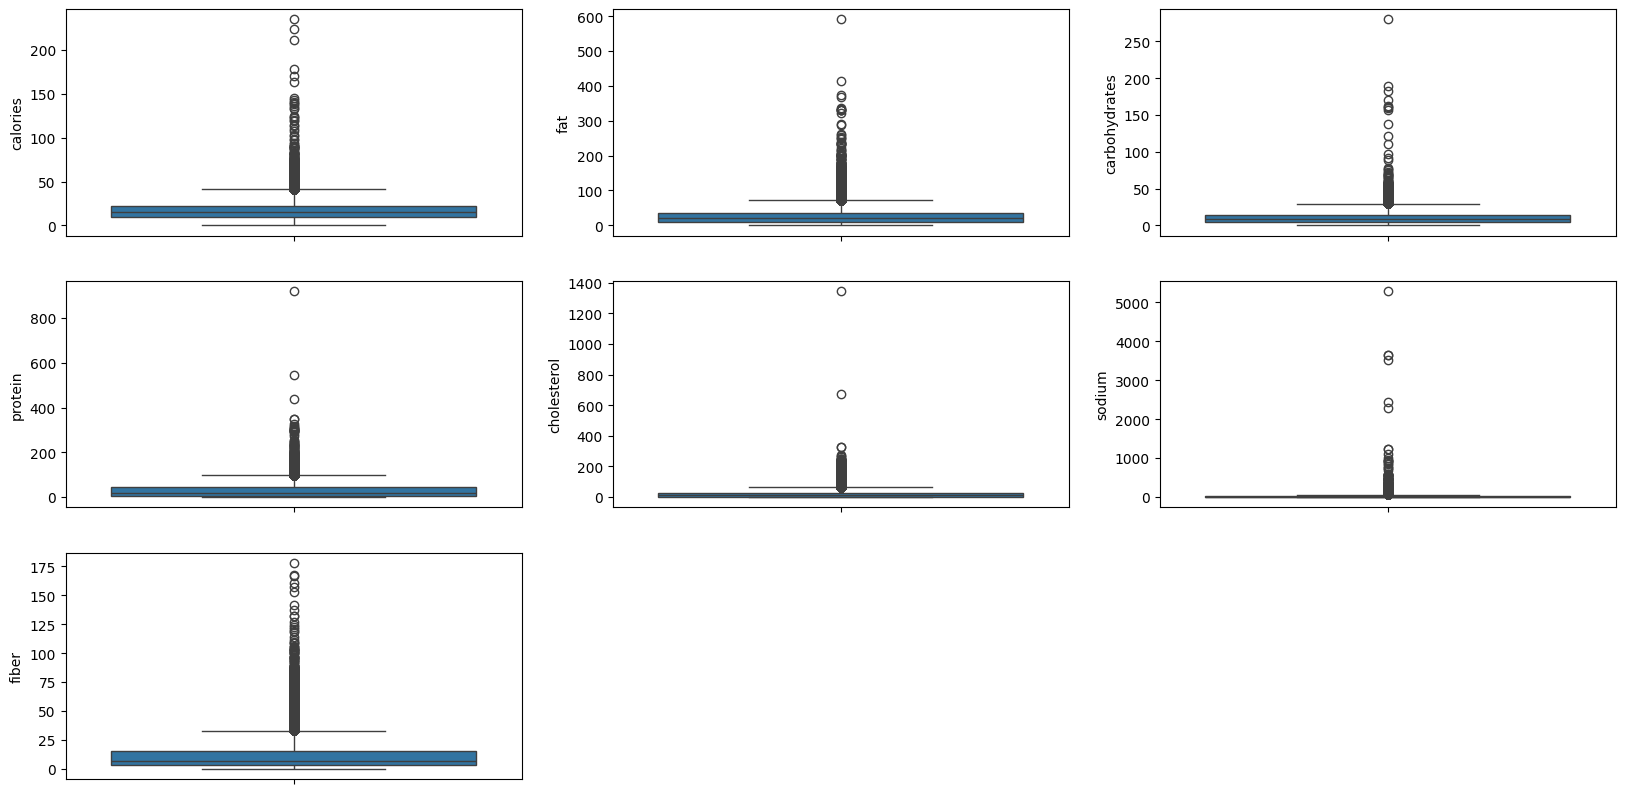

In [ ]:
#getting box plots
data = df.select_dtypes(include=['int64', 'float64'])
plt.figure(figsize=(20, 10))
for i in range(len(data.columns)):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(data[data.columns[i]])
plt.show()

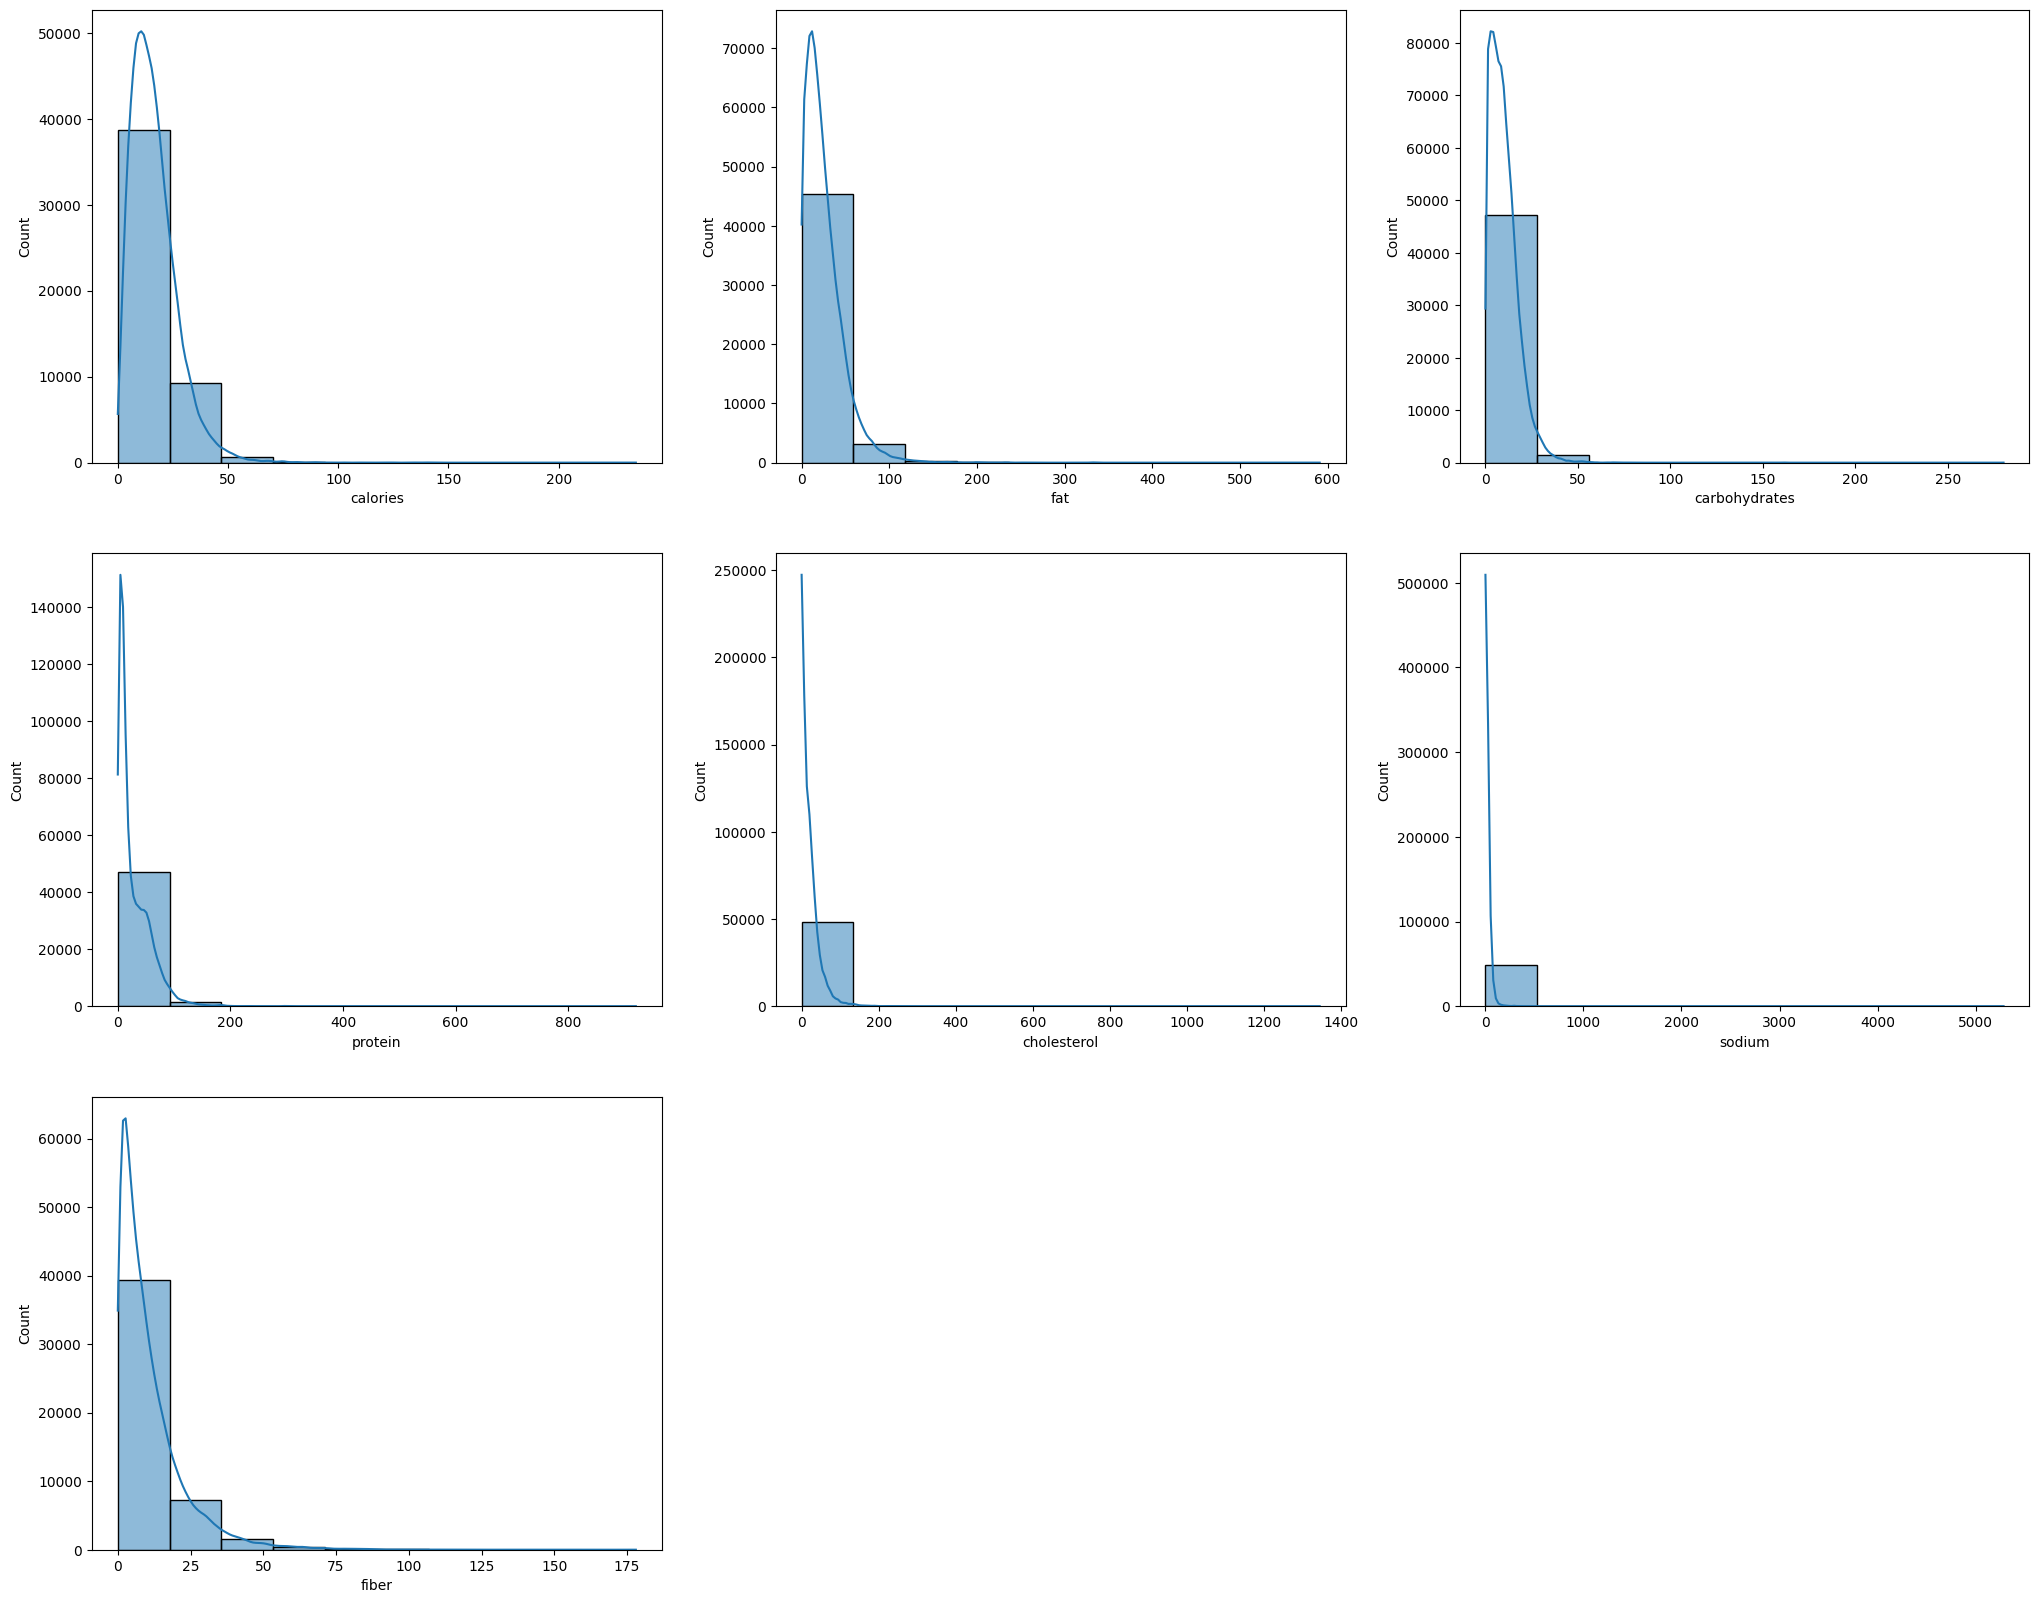

In [ ]:
# Ploting a histogram to visualize the descriptive statistics of each variable before normalizing the data
data = df.select_dtypes(include=['int64', 'float64'])
plt.figure(figsize=(25,20))
for i, col in enumerate(data.columns):
    plt.subplot(3,3, i+1)
    sns.histplot(data=df, x=col, bins=10, kde=True)
    plt.tight_layout

plt.show()

Normalizing the data

In [ ]:
# normalizing nutrition data by columns
df_normalized = pd.DataFrame(normalize(df, axis=0))
df_normalized.columns = df.columns
df_normalized.index = df.index
df_normalized.head()

calories       fat  carbohydrates   protein  cholesterol    sodium  \
recipe_id                                                                       
222388     0.003457  0.004775       0.000352  0.004739     0.002997  0.006572   
240488     0.004378  0.002387       0.003517  0.008236     0.004710  0.008438   
218939     0.003917  0.004775       0.000703  0.005416     0.003425  0.002515   
87211      0.007374  0.005969       0.007034  0.007334     0.002855  0.003489   
245714     0.001844  0.001592       0.001759  0.001580     0.000999  0.000649   

              fiber  
recipe_id            
222388     0.000560  
240488     0.011477  
218939     0.001120  
87211      0.005039  
245714     0.000840

In [ ]:
df_normalized.tail()

calories       fat  carbohydrates   protein  cholesterol    sodium  \
recipe_id                                                                       
222886     0.004609  0.000133       0.002110  0.000113     0.000000  0.000081   
25650      0.001383  0.001857       0.000703  0.000451     0.001855  0.000243   
23544      0.001844  0.000928       0.002814  0.001128     0.000428  0.000243   
170710     0.004609  0.004377       0.005627  0.001241     0.003568  0.000568   
79774      0.000461  0.000398       0.000703  0.000338     0.000000  0.001298   

              fiber  
recipe_id            
222886     0.000000  
25650      0.000280  
23544      0.002239  
170710     0.001400  
79774      0.001680

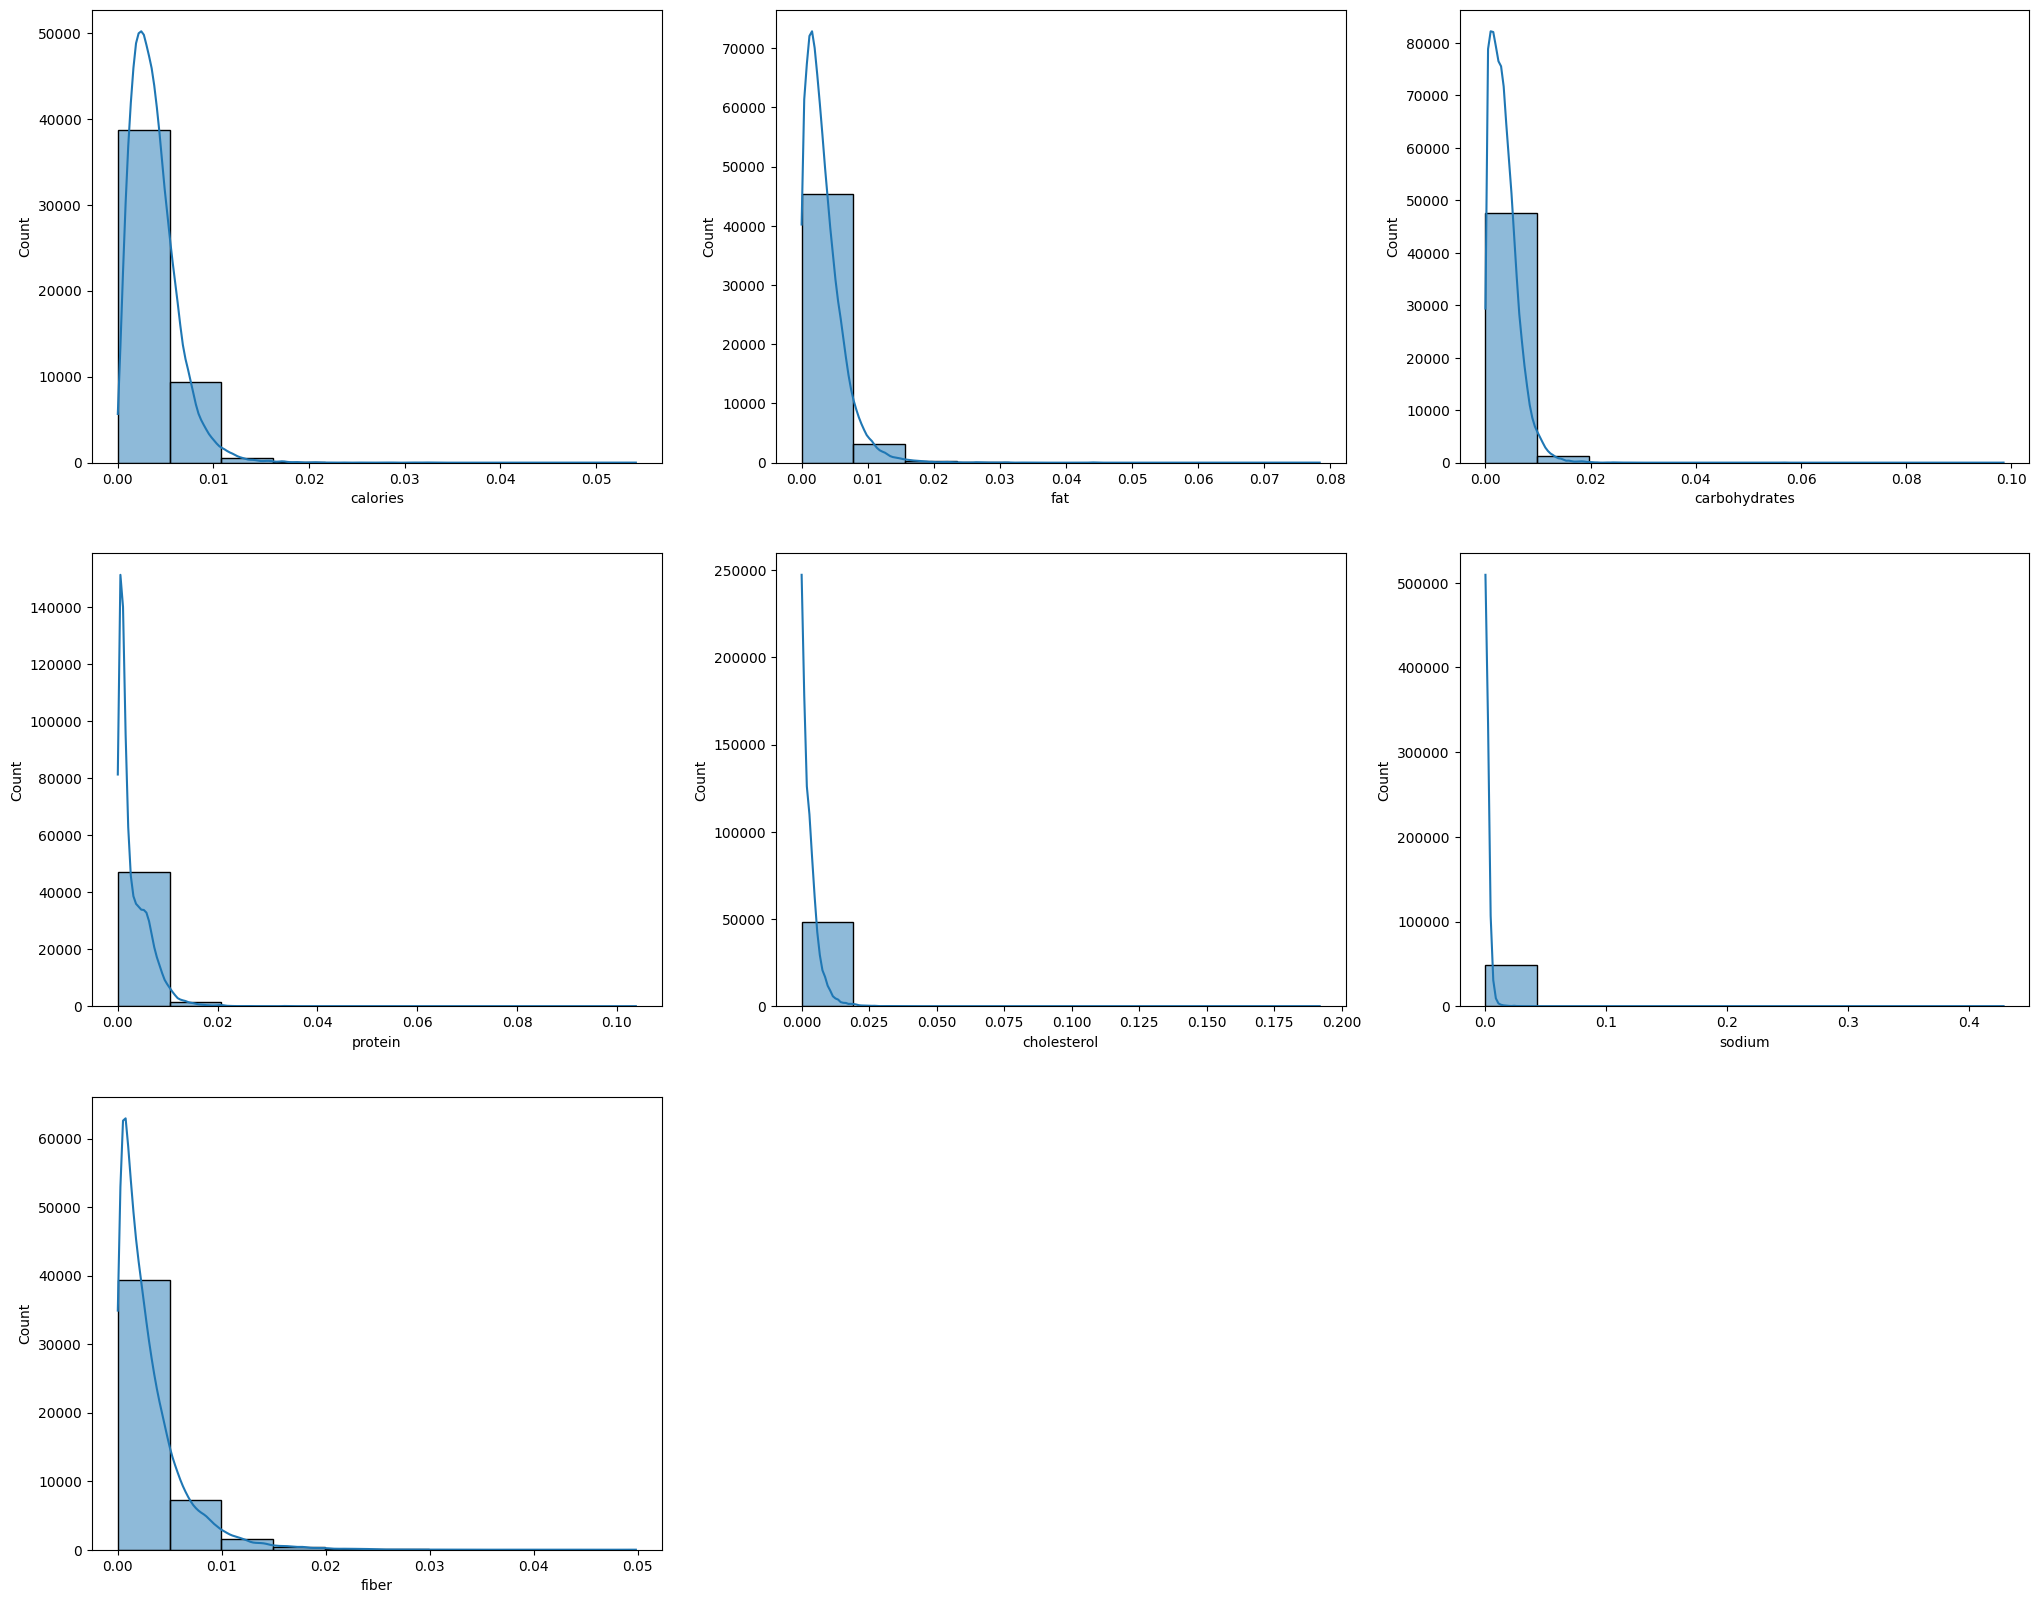

In [ ]:
# Ploting a histogram to visualize the descriptive statistics of each variable after normalizing the data
data = df_normalized.select_dtypes(include=['int64', 'float64'])
plt.figure(figsize=(25,20))
for i, col in enumerate(data.columns):
    plt.subplot(3,3, i+1)
    sns.histplot(data=df_normalized, x=col, bins=10, kde=True)
    plt.tight_layout

plt.show()

Building a KNN model

In [ ]:
# show recipe id, recipe name and image of selected recipe
def selected_recipe(recipe_id):
    image_path = "/content/drive/MyDrive/raw-data-images/raw-data-images/{}.jpg"
    image_path = image_path.format(recipe_id)

    img = image.load_img(image_path)
    img = image.img_to_array(img, dtype='int')

    fig, ax = plt.subplots(1,1)
    ax.imshow(img)
    ax.axis('off')

    recipe_df = recipe.set_index('recipe_id')
    x = "{}  {}".format(recipe_id, recipe_df.at[recipe_id, 'recipe_name'])
    ax.set_title(x)

In [ ]:
"""
KNN Recommender based on different distance calculation approaches

df_normalized: normalized nutrition data
distance_method: distance calculation approach: e.g. cosine, euclidean, hamming
recipe_id: find similar recipes based on the selected recipe
N: Top N recipe(s)

return 1) nutrition data of selected recipe and Top N recommendation,
2) recipe id, recipe name and image of Top N recommendation
"""
def knn_recommender(distance_method, recipe_id, N):
    start = time()

    allRecipes = pd.DataFrame(df_normalized.index)
    allRecipes = allRecipes[allRecipes.recipe_id != recipe_id]
    allRecipes["distance"] = allRecipes["recipe_id"].apply(lambda x: distance_method(df_normalized.loc[recipe_id], df_normalized.loc[x]))
    TopNRecommendation = allRecipes.sort_values(["distance"]).head(N).sort_values(by=['distance', 'recipe_id'])

    recipe_df = recipe.set_index('recipe_id')
    recipe_id = [recipe_id]
    recipe_list = []
    image_list = []
    image_path = "/content/drive/MyDrive/raw-data-images/raw-data-images/{}.jpg"
    for recipeid in TopNRecommendation.recipe_id:
        recipe_id.append(recipeid)   # list of recipe id of selected recipe and recommended recipe(s)
        recipe_list.append("{}  {}".format(recipeid, recipe_df.at[recipeid, 'recipe_name']))
        image_list.append(image_path.format(recipeid))

    image_array = []
    for imagepath in image_list:
        img = image.load_img(imagepath)
        img = image.img_to_array(img, dtype='int')
        image_array.append(img)

    fig = plt.figure(figsize=(15,15))
    gs1 = gridspec.GridSpec(1, N)
    axs = []
    for x in range(N):
        axs.append(fig.add_subplot(gs1[x]))
        axs[-1].imshow(image_array[x])
    [axi.set_axis_off() for axi in axs]
    for axi, x in zip(axs, recipe_list):
        axi.set_title(x)

    end = time()
    running_time = end - start
    print('time cost: %.5f sec' %running_time)

    return df_normalized.loc[recipe_id, :]

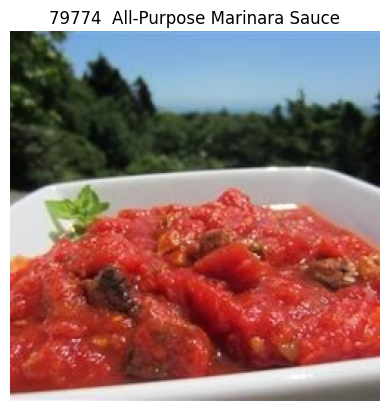

In [ ]:
selected_recipe(79774)

time cost: 8.49380 sec


calories       fat  carbohydrates   protein  cholesterol    sodium  \
recipe_id                                                                       
79774      0.000461  0.000398       0.000703  0.000338          0.0  0.001298   
159723     0.001383  0.001061       0.002110  0.000790          0.0  0.003570   
25725      0.000922  0.000663       0.001407  0.000451          0.0  0.002434   
88986      0.000691  0.000398       0.001055  0.000451          0.0  0.001623   

              fiber  
recipe_id            
79774      0.001680  
159723     0.005039  
25725      0.003079  
88986      0.002239

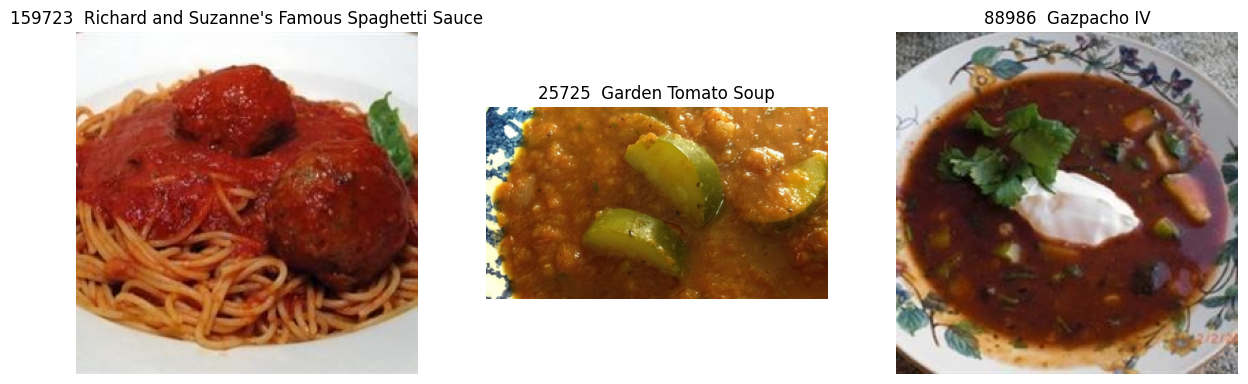

In [ ]:
knn_recommender(cosine, 79774, 3)

time cost: 6.29685 sec


calories       fat  carbohydrates   protein  cholesterol    sodium  \
recipe_id                                                                       
79774      0.000461  0.000398       0.000703  0.000338     0.000000  0.001298   
244415     0.000461  0.000265       0.000703  0.000338     0.000143  0.001298   
23967      0.000691  0.000531       0.000703  0.000338     0.000000  0.001460   
38507      0.000461  0.000265       0.000703  0.000338     0.000000  0.001217   

             fiber  
recipe_id           
79774      0.00168  
244415     0.00168  
23967      0.00168  
38507      0.00140

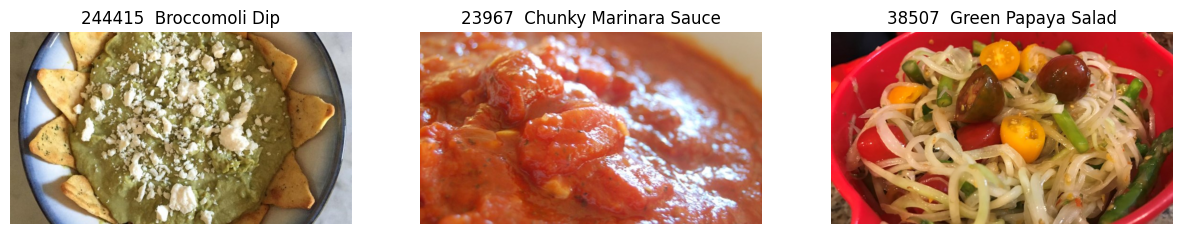

In [ ]:
knn_recommender(euclidean, 79774, 3)

time cost: 6.47379 sec


calories       fat  carbohydrates   protein  cholesterol    sodium  \
recipe_id                                                                       
79774      0.000461  0.000398       0.000703  0.000338          0.0  0.001298   
78545      0.000461  0.000398       0.000703  0.000451          0.0  0.000162   
90547      0.000461  0.000133       0.000703  0.000338          0.0  0.000649   
140294     0.000461  0.000265       0.000703  0.000338          0.0  0.001298   

              fiber  
recipe_id            
79774      0.001680  
78545      0.001680  
90547      0.001680  
140294     0.002239

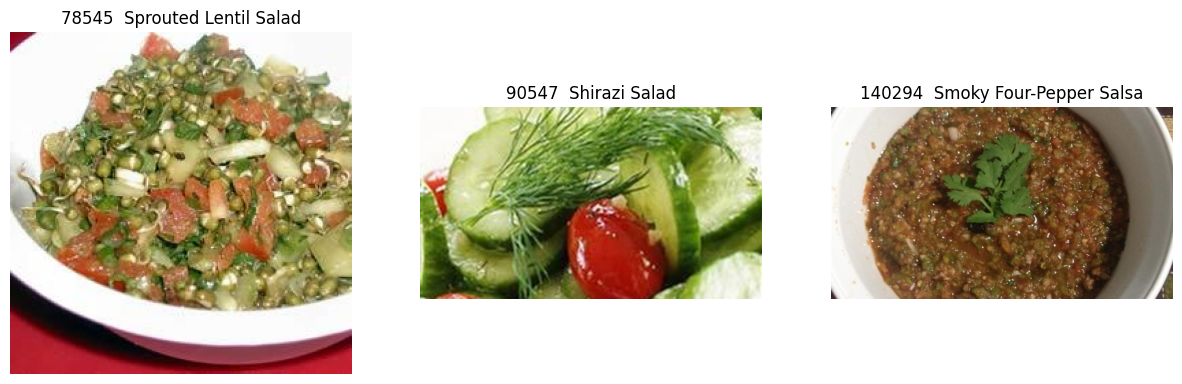

In [ ]:
knn_recommender(hamming, 79774, 3)

In [ ]:
"""
Hybrid Nutrition Recommender which integrates Top 2 recommendations from 3 different distance approaches
(cosine, euclidean, hamming) and sort the results by selected criteria(s)
df_normalized: normalized nutrition data
recipe_id: find similar recipes based on the selected recipe
sort_order: must be in list, 4 options available: ['aver_rate'], ['review_nums'], ['aver_rate', 'review_nums'], ['review_nums', 'aver_rate']
N: Top N recipe(s)
returns
1) recipe id, recipe name and image of Top N recommendation,
2) nutrition data of selected recipe and Top N recommendation,
3) average rating and number of review of Top N recommendation
"""
def HybridNutritionRecommender3(recipe_id, sort_order, N):
    start = time()

    allRecipes_cosine = pd.DataFrame(df_normalized.index)
    allRecipes_cosine = allRecipes_cosine[allRecipes_cosine.recipe_id != recipe_id]
    allRecipes_cosine["distance"] = allRecipes_cosine["recipe_id"].apply(lambda x: cosine(df_normalized.loc[recipe_id], df_normalized.loc[x]))

    allRecipes_euclidean = pd.DataFrame(df_normalized.index)
    allRecipes_euclidean = allRecipes_euclidean[allRecipes_euclidean.recipe_id != recipe_id]
    allRecipes_euclidean["distance"] = allRecipes_euclidean["recipe_id"].apply(lambda x: euclidean(df_normalized.loc[recipe_id], df_normalized.loc[x]))

    allRecipes_hamming = pd.DataFrame(df_normalized.index)
    allRecipes_hamming = allRecipes_hamming[allRecipes_hamming.recipe_id != recipe_id]
    allRecipes_hamming["distance"] = allRecipes_hamming["recipe_id"].apply(lambda x: hamming(df_normalized.loc[recipe_id], df_normalized.loc[x]))

    Top2Recommendation_cosine = allRecipes_cosine.sort_values(["distance"]).head(2).sort_values(by=['distance', 'recipe_id'])
    Top2Recommendation_euclidean = allRecipes_euclidean.sort_values(["distance"]).head(2).sort_values(by=['distance', 'recipe_id'])
    Top2Recommendation_hamming = allRecipes_hamming.sort_values(["distance"]).head(2).sort_values(by=['distance', 'recipe_id'])

    recipe_df = recipe.set_index('recipe_id')
    hybrid_Top6Recommendation = pd.concat([Top2Recommendation_cosine, Top2Recommendation_euclidean, Top2Recommendation_hamming])
    aver_rate_list = []
    review_nums_list = []
    for recipeid in hybrid_Top6Recommendation.recipe_id:
        aver_rate_list.append(recipe_df.at[recipeid, 'aver_rate'])
        review_nums_list.append(recipe_df.at[recipeid, 'review_nums'])
    hybrid_Top6Recommendation['aver_rate'] = aver_rate_list
    hybrid_Top6Recommendation['review_nums'] = review_nums_list
    TopNRecommendation = hybrid_Top6Recommendation.sort_values(by=sort_order, ascending=False).head(N).drop(columns=['distance'])

    recipe_id = [recipe_id]
    recipe_list = []
    for recipeid in TopNRecommendation.recipe_id:
        recipe_id.append(recipeid)   # list of recipe id of selected recipe and recommended recipe(s)
        recipe_list.append("{}  {}".format(recipeid, recipe_df.at[recipeid, 'recipe_name']))

    image_list = []
    image_path = "/content/drive/MyDrive/raw-data-images/raw-data-images/{}.jpg"
    for recipeid in TopNRecommendation.recipe_id:
        image_list.append(image_path.format(recipeid))

    image_array = []
    for imagepath in image_list:
        img = image.load_img(imagepath)
        img = image.img_to_array(img, dtype='int')
        image_array.append(img)

    fig = plt.figure(figsize=(15,15))
    gs1 = gridspec.GridSpec(1, N)
    axs = []
    for x in range(N):
        axs.append(fig.add_subplot(gs1[x]))
        axs[-1].imshow(image_array[x])
    [axi.set_axis_off() for axi in axs]
    for axi, x in zip(axs, recipe_list):
        axi.set_title(x)

    end = time()
    running_time = end - start
    print('time cost: %.5f sec' %running_time)
    return df_normalized.loc[recipe_id, :], TopNRecommendation

time cost: 23.09070 sec


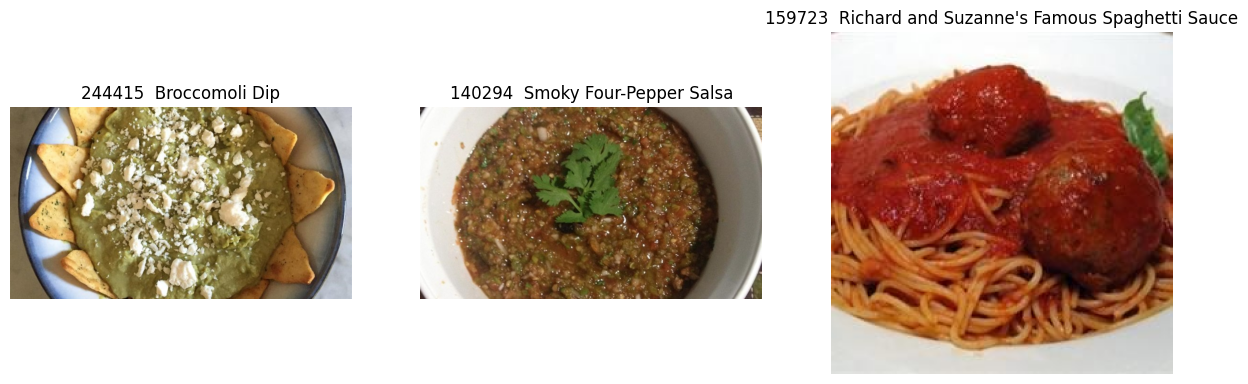

In [ ]:
nutrition_ar, topN_ar = HybridNutritionRecommender3(79774, ['aver_rate'], 3)

In [ ]:
nutrition_ar

calories       fat  carbohydrates   protein  cholesterol    sodium  \
recipe_id                                                                       
79774      0.000461  0.000398       0.000703  0.000338     0.000000  0.001298   
244415     0.000461  0.000265       0.000703  0.000338     0.000143  0.001298   
140294     0.000461  0.000265       0.000703  0.000338     0.000000  0.001298   
159723     0.001383  0.001061       0.002110  0.000790     0.000000  0.003570   

              fiber  
recipe_id            
79774      0.001680  
244415     0.001680  
140294     0.002239  
159723     0.005039

In [ ]:
topN_ar

recipe_id  aver_rate  review_nums
17619     244415       5.00            2
16075     140294       4.79           11
48728     159723       4.65           22

time cost: 30.32353 sec


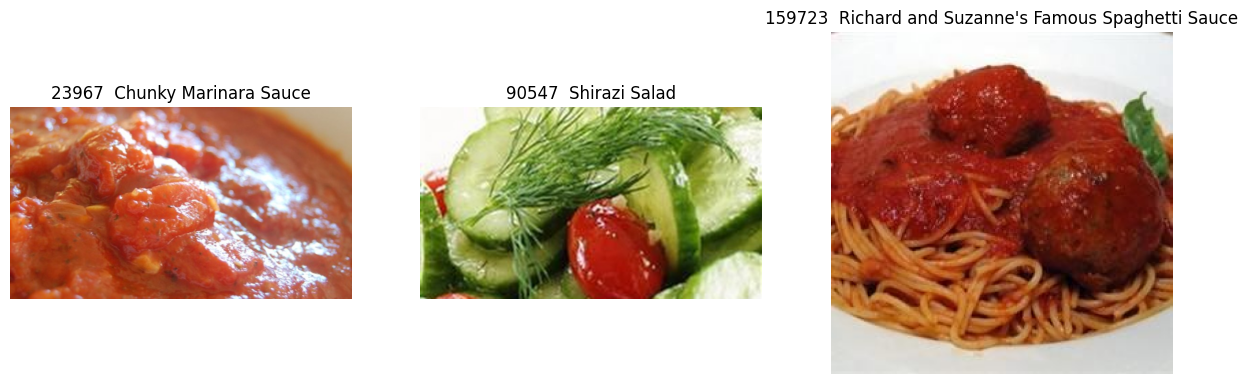

In [ ]:
nutrition_rn, topN_rn = HybridNutritionRecommender3(79774, ['review_nums'], 3)

In [ ]:
nutrition_rn

calories       fat  carbohydrates   protein  cholesterol    sodium  \
recipe_id                                                                       
79774      0.000461  0.000398       0.000703  0.000338          0.0  0.001298   
23967      0.000691  0.000531       0.000703  0.000338          0.0  0.001460   
90547      0.000461  0.000133       0.000703  0.000338          0.0  0.000649   
159723     0.001383  0.001061       0.002110  0.000790          0.0  0.003570   

              fiber  
recipe_id            
79774      0.001680  
23967      0.001680  
90547      0.001680  
159723     0.005039

In [ ]:
topN_rn

recipe_id  aver_rate  review_nums
48143      23967       4.44          123
37065      90547       4.17           36
48728     159723       4.65           22

In [ ]:
def levenshtein_distance(str1, str2):
  """
  Calculates the Levenshtein distance between two strings.

  Args:
      str1 (str): The first string.
      str2 (str): The second string.

  Returns:
      int: The Levenshtein distance between the two strings.
  """
  m = len(str1) + 1
  n = len(str2) + 1
  dp = [[0 for _ in range(n)] for _ in range(m)]

  # Initialize the first row and column with insertion costs
  for i in range(1, m):
    dp[i][0] = i
  for j in range(1, n):
    dp[0][j] = j

  # Fill the DP table with minimum edit costs
  for i in range(1, m):
    for j in range(1, n):
      if str1[i-1] == str2[j-1]:
        cost = 0
      else:
        cost = 1
      dp[i][j] = min(dp[i-1][j] + 1,  # Insertion
                     dp[i][j-1] + 1,  # Deletion
                     dp[i-1][j-1] + cost)  # Substitution

  return dp[m-1][n-1]

In [ ]:
"""
Hybrid Nutrition Recommender which integrates Top 2 recommendations from 4 different distance approaches
(cosine, euclidean, levenshtein, hamming) and sort the results by selected criteria(s)
df_normalized: normalized nutrition data
recipe_id: find similar recipes based on the selected recipe
sort_order: must be in list, 4 options available: ['aver_rate'], ['review_nums'], ['aver_rate', 'review_nums'], ['review_nums', 'aver_rate']
N: Top N recipe(s)
returns
1) recipe id, recipe name and image of Top N recommendation,
2) nutrition data of selected recipe and Top N recommendation,
3) average rating and number of review of Top N recommendation
"""

def nutrition_hybrid_recommender4(recipe_id, sort_order, N):
    start = time()

    allRecipes_cosine = pd.DataFrame(df_normalized.index)
    allRecipes_cosine = allRecipes_cosine[allRecipes_cosine.recipe_id != recipe_id]
    allRecipes_cosine["distance"] = allRecipes_cosine["recipe_id"].apply(lambda x: cosine(df_normalized.loc[recipe_id], df_normalized.loc[x]))

    allRecipes_euclidean = pd.DataFrame(df_normalized.index)
    allRecipes_euclidean = allRecipes_euclidean[allRecipes_euclidean.recipe_id != recipe_id]
    allRecipes_euclidean["distance"] = allRecipes_euclidean["recipe_id"].apply(lambda x: euclidean(df_normalized.loc[recipe_id], df_normalized.loc[x]))

    # Locate the row where recipe_id matches and retrieve the corresponding recipe name
    target_recipe_name = recipe_names.loc[recipe_names['recipe_id'] == recipe_id, 'recipe_name'].iloc[0]

    # Calculate Levenshtein distance for each recipe name compared to the target recipe name
    distances = []
    for x in df_normalized.index:
        # Locate the row where recipe_id matches x and retrieve the corresponding recipe name
        x_recipe_name = recipe_names.loc[recipe_names['recipe_id'] == x, 'recipe_name'].iloc[0]
        distances.append(levenshtein_distance(target_recipe_name, x_recipe_name))

    # Create a DataFrame to store the distances
    allRecipes_levenshtein = pd.DataFrame(df_normalized.index, columns=['recipe_id'])
    allRecipes_levenshtein["distance"] = distances

    allRecipes_hamming = pd.DataFrame(df_normalized.index)
    allRecipes_hamming = allRecipes_hamming[allRecipes_hamming.recipe_id != recipe_id]
    allRecipes_hamming["distance"] = allRecipes_hamming["recipe_id"].apply(lambda x: hamming(df_normalized.loc[recipe_id], df_normalized.loc[x]))

    Top2Recommendation_cosine = allRecipes_cosine.sort_values(["distance"]).head(2).sort_values(by=['distance', 'recipe_id'])
    Top2Recommendation_euclidean = allRecipes_euclidean.sort_values(["distance"]).head(2).sort_values(by=['distance', 'recipe_id'])
    Top2Recommendation_levenshtein = allRecipes_levenshtein.sort_values(["distance"]).head(2).sort_values(by=['distance', 'recipe_id'])
    Top2Recommendation_hamming = allRecipes_hamming.sort_values(["distance"]).head(2).sort_values(by=['distance', 'recipe_id'])

    recipe_df = recipe.set_index('recipe_id')
    hybrid_Top8Recommendation = pd.concat([Top2Recommendation_cosine, Top2Recommendation_euclidean, Top2Recommendation_levenshtein, Top2Recommendation_hamming])

    # Calculate average rate and review numbers for recommendations
    hybrid_Top8Recommendation['aver_rate'] = hybrid_Top8Recommendation['recipe_id'].apply(lambda x: recipe_df.at[x, 'aver_rate'])
    hybrid_Top8Recommendation['review_nums'] = hybrid_Top8Recommendation['recipe_id'].apply(lambda x: recipe_df.at[x, 'review_nums'])

    # Sort recommendations based on the specified sorting order and select top N
    TopNRecommendation = hybrid_Top8Recommendation.sort_values(by=sort_order, ascending=False).head(N).drop(columns=['distance'])

    # Retrieve information about the recommended recipes
    recommended_recipe_ids = [recipe_id] + list(TopNRecommendation['recipe_id'])
    recommended_recipe_names = [f"{rid} {recipe_df.at[rid, 'recipe_name']}" for rid in recommended_recipe_ids]
    image_list = [ "/content/drive/MyDrive/raw-data-images/raw-data-images/{}.jpg".format(rid) for rid in recommended_recipe_ids]

    # Load images
    image_array = []
    for imagepath in image_list:
        img = image.load_img(imagepath)
        img = image.img_to_array(img, dtype='int')
        image_array.append(img)
    # Plot images and names
    fig = plt.figure(figsize=(15, 15))
    gs1 = gridspec.GridSpec(1, len(image_array))  # Adjust the number of subplots dynamically
    unique_recipe_names = set()  # Set to store unique recipe names

    axs = []
    for idx, img in enumerate(image_array):
        recipe_name = recommended_recipe_names[idx]
        if recipe_name not in unique_recipe_names:
            unique_recipe_names.add(recipe_name)  # Add to set if not seen before
            axs.append(fig.add_subplot(gs1[len(unique_recipe_names)-1]))
            axs[-1].imshow(img)
            axs[-1].set_title(recipe_name)
            axs[-1].set_axis_off()

    # Print unique recipe names
    for name in unique_recipe_names:
       print(name)
    end = time()
    running_time = end - start
    print('time cost: %.5f sec' % running_time)

    return df_normalized.loc[recommended_recipe_ids, :], TopNRecommendation

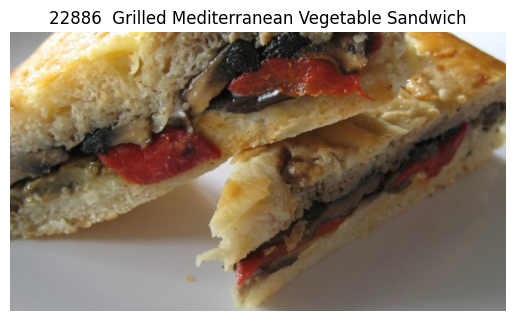

In [ ]:
selected_recipe(22886)

22886 Grilled Mediterranean Vegetable Sandwich
231104 Sandy's Greek Pasta Salad
78007 Mediterranean Vegetable Stew
time cost: 79.53395 sec


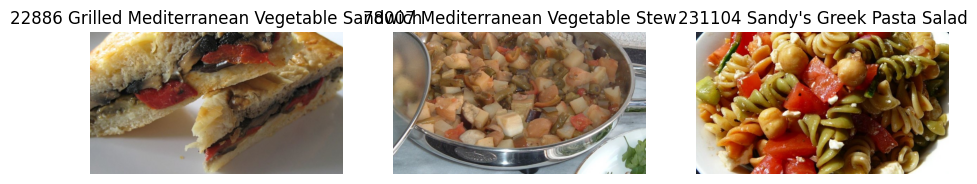

In [ ]:
nutrition_rn, topN_rn = nutrition_hybrid_recommender4(22886, ['review_nums'], 3)

In [ ]:
nutrition_rn

calories       fat  carbohydrates   protein  cholesterol    sodium  \
recipe_id                                                                       
22886      0.004148  0.003051       0.005627  0.002031     0.000143  0.001623   
22886      0.004148  0.003051       0.005627  0.002031     0.000143  0.001623   
78007      0.002535  0.001724       0.003869  0.001467     0.000000  0.001623   
231104     0.003917  0.002520       0.005627  0.002369     0.000428  0.001298   

              fiber  
recipe_id            
22886      0.006158  
22886      0.006158  
78007      0.008958  
231104     0.005599

In [ ]:
topN_rn

recipe_id  aver_rate  review_nums
30897      22886       4.58          108
34962      78007       4.22           39
35766     231104       4.25            8

245387 Perfect and Delicious Royal Icing
222420 Rob Roy Cocktail
234414 Liquid Vampire
222886 Grateful Dead Cocktail
time cost: 65.52731 sec


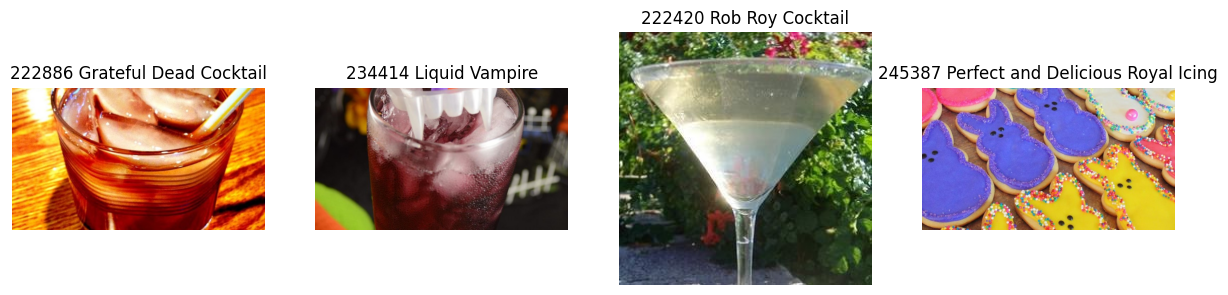

In [ ]:
nutrition_ar, topN_ar = nutrition_hybrid_recommender4(222886, ['aver_rate'], 3)

In [ ]:
nutrition_ar

calories       fat  carbohydrates   protein  cholesterol    sodium  \
recipe_id                                                                       
222886     0.004609  0.000133       0.002110  0.000113          0.0  0.000081   
234414     0.002074  0.000133       0.001055  0.000113          0.0  0.000081   
222420     0.004609  0.000000       0.002814  0.000113          0.0  0.000081   
245387     0.000922  0.000133       0.002110  0.000113          0.0  0.000081   

           fiber  
recipe_id         
222886       0.0  
234414       0.0  
222420       0.0  
245387       0.0

In [ ]:
topN_ar

recipe_id  aver_rate  review_nums
48256     234414        5.0            7
46605     222420        5.0            1
46420     245387        5.0            1

In [ ]:
def create_ground_truth(df, rating_threshold=4.0, review_threshold=100):
    """
    Create ground truth data based on 'aver_rate' and 'review_nums' columns.
    Args:
    - df: DataFrame containing recipe data
    - rating_threshold (float): Threshold for average rating (default: 4.0)
    - review_threshold (int): Threshold for review numbers (default: 100)
    Returns:
    - ground_truth: DataFrame containing ground truth data
    """
    good_ratings = df[df['aver_rate'] >= rating_threshold]
    popular_recipes = df[df['review_nums'] >= review_threshold]
    # Combine good ratings and popular recipes to create ground truth
    ground_truth = pd.concat([good_ratings, popular_recipes]).drop_duplicates()
    return ground_truth

In [ ]:
ground_truth = create_ground_truth(recipe)

Model Evaluation

In [ ]:
def compute_evaluation_metrics(recommended_ids, ground_truth_recipe_ids):
    # Computing true positives (intersection of recommended IDs and ground truth IDs)
    true_positives = len(set(recommended_ids) & set(ground_truth['recipe_id']))
    print('True Positives: ', true_positives)
    # Computing false positives (recommended IDs not in ground truth)
    false_positives = len(set(recommended_ids) - set(ground_truth['recipe_id']))
    print('False Positives: ', false_positives)
    # Computing false negatives (ground truth IDs not in recommended IDs)
    false_negatives = len(set(ground_truth['recipe_id']) - set(recommended_ids))
    print('False Negatives: ', false_negatives)
    # Computing precision
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    # Computing recall
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    # Computing coverage
    coverage = len(set(recommended_ids)) / len(set(ground_truth['recipe_id'])) if len(set(ground_truth['recipe_id'])) > 0 else 0
    return precision, recall, coverage


In [ ]:
# recommended_recipe_ids contains the IDs of recommended recipes
recommended_recipe_ids = topN_ar['recipe_id'].tolist()
# Compute accuracy and precision metrics
precision, recall, coverage = compute_evaluation_metrics(recommended_recipe_ids, ground_truth)
print("Precision:", precision)
print("Recall:", recall)
print("Coverage:", coverage)

True Positives:  3
False Positives:  0
False Negatives:  41941
Precision: 1.0
Recall: 7.152393667747473e-05
Coverage: 7.152393667747473e-05
